In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib64/python3.12/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


In [2]:
# --- CONFIGURATION ---
# AllenAI/OLMoE-1B-7B-0924 is a state-of-the-art open MoE
# Total Params: ~7B | Active Params: ~1B
MODEL_ID = "AllenAI/OLMoE-1B-7B-0924"

print(f"Loading {MODEL_ID}...")
# 1. Configure 4-bit Quantization (Crucial for 12GB VRAM)
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

Loading AllenAI/OLMoE-1B-7B-0924...


In [3]:
# 2. Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [4]:
# 3. Load Model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=quant_config, # This shrinks model to ~5GB
    device_map="auto",
    #trust_remote_code=True
)
print(f"Model loaded on {model.device}!")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded on cuda:0!


In [5]:
# --- 1. RESET & RE-HOOK ---
# Clear any old hooks from previous runs to prevent duplicates/errors
print("Clearing old hooks...")
for name, module in model.named_modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()

# Define the precise hook
router_logs = {}
def get_router_hook(layer_name):
    def hook(module, inputs, outputs):
        # Robustly handle tuple vs tensor outputs
        if isinstance(outputs, tuple):
            val = outputs[1] # Usually [1] is the router logits
        else:
            val = outputs
        
        # Only save if it looks like router logits: [batch, seq_len, 64]
        if isinstance(val, torch.Tensor) and val.shape[-1] == 64:
            router_logs[layer_name] = val.detach().float().cpu()
    return hook

print("Attaching precision hooks...")
hook_count = 0
for name, module in model.named_modules():
    # FIX: Use .endswith() to target ONLY the router, ignoring expert internals
    if name.endswith("mlp.gate"): 
        module.register_forward_hook(get_router_hook(name))
        hook_count += 1

print(f"Attached {hook_count} hooks (Should be 16 for OLMoE-1B-7B).")

Clearing old hooks...
Attaching precision hooks...
Attached 16 hooks (Should be 16 for OLMoE-1B-7B).


In [6]:
# 1. Run Inference
text = "The quick brown fox jumps. 안녕하세요. こんにちは."
inputs = tokenizer(text, return_tensors="pt").to(model.device)

router_logs = {} 
with torch.no_grad():
    outputs = model(**inputs)

Debug: Logits shape is (23, 64)

--- Routing Analysis: model.layers.14.mlp.gate ---

TOKEN           | CHOSEN EXPERT
-----------------------------------
The             | Expert 60
quick           | Expert 46
brown           | Expert 4
fox             | Expert 50
jumps           | Expert 4
.               | Expert 11
�               | Expert 13
�               | Expert 13
�               | Expert 13
�               | Expert 13
�               | Expert 13
하               | Expert 13
�               | Expert 13
�               | Expert 13
요               | Expert 13
.               | Expert 42
                | Expert 24
こ               | Expert 13
ん               | Expert 13
に               | Expert 13
ち               | Expert 39
は               | Expert 51
.               | Expert 51


/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12371 (\N{HIRAGANA LETTER KO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12435 (\N{HIRAGANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py

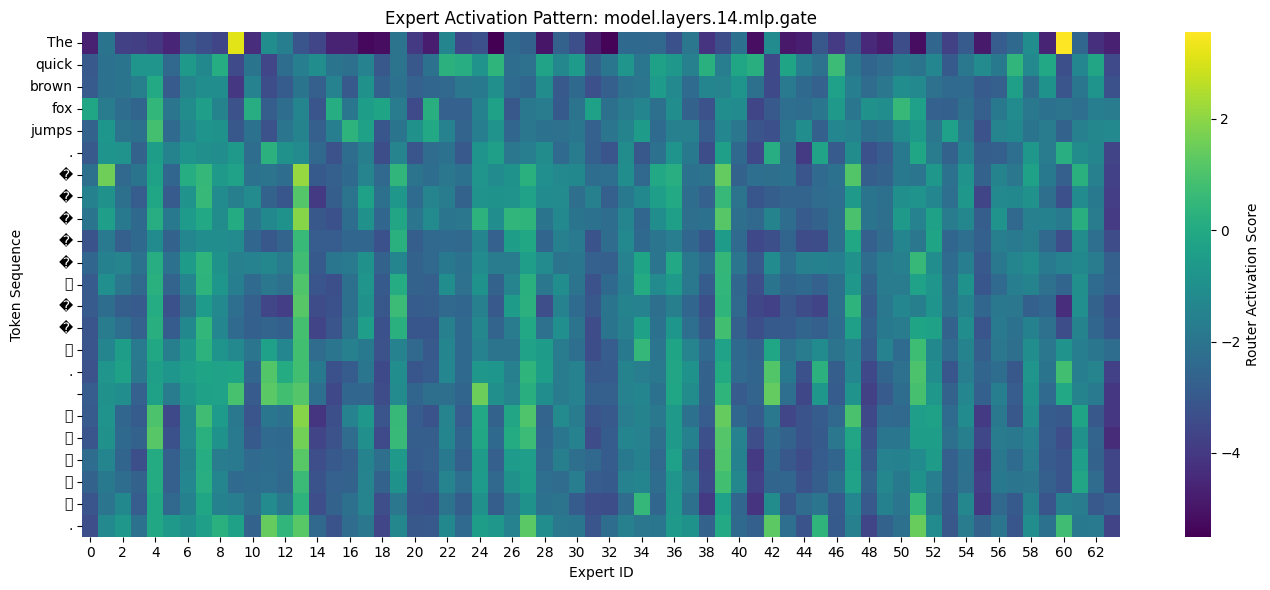

In [7]:
# 2. Visualize
target_layer_key = next((k for k in router_logs.keys() if ".14." in k), None)

if target_layer_key:
    logits = router_logs[target_layer_key].numpy()
    
    # --- FIX START: Handle Shape Mismatch ---
    print(f"Debug: Logits shape is {logits.shape}")
    
    if logits.ndim == 3:
        # Case: [Batch, Seq, Experts] -> Take first batch item
        data_to_plot = logits[0]
    else:
        # Case: [Seq, Experts] -> Already flattened, use as is
        data_to_plot = logits
    # --- FIX END ---

    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    token_labels = [tokenizer.convert_tokens_to_string([t]).strip() for t in tokens]
    
    # Safety check: Ensure data length matches tokens
    if len(token_labels) != len(data_to_plot):
        print(f"⚠️ Warning: Token count ({len(token_labels)}) != Logits count ({len(data_to_plot)})")
        # Truncate to the shorter one to prevent crash
        min_len = min(len(token_labels), len(data_to_plot))
        token_labels = token_labels[:min_len]
        data_to_plot = data_to_plot[:min_len]

    # Print Table
    top_experts = np.argmax(data_to_plot, axis=-1)
    
    print(f"\n--- Routing Analysis: {target_layer_key} ---\n")
    print(f"{'TOKEN':<15} | {'CHOSEN EXPERT'}")
    print("-" * 35)
    for t_str, expert in zip(token_labels, top_experts):
        clean_token = t_str.replace('Ġ', '').replace('Ċ', '')
        print(f"{clean_token:<15} | Expert {expert}")

    # Plot Heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        data_to_plot, 
        cmap="viridis", 
        yticklabels=token_labels,
        cbar_kws={'label': 'Router Activation Score'}
    )
    plt.title(f"Expert Activation Pattern: {target_layer_key}")
    plt.xlabel("Expert ID")
    plt.ylabel("Token Sequence")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Could not find Layer 14. Available layers:", list(router_logs.keys()))